In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_figlet.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_figlettest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.324094,0.006131,911.319040,49312.485831,0.010610,1355.186590,7327.460939,1.0,103.0,0.101562,6.0,65.278711,2.508814e+10,19.192693
1,0.435870,0.012711,12652.088889,99214.222222,0.010610,5997.000000,17316.288889,1.0,251.0,0.103955,6.0,65.278711,2.508814e+10,19.192693
2,0.468027,0.012978,12652.088889,101398.755556,0.033712,8108.177778,21682.377778,1.0,396.0,0.106485,6.0,11.526728,2.508814e+10,19.333974
3,0.465293,0.014400,11832.888889,128341.333333,0.033712,9869.933333,22551.844444,1.0,542.0,0.105202,6.0,11.526728,2.508814e+10,19.333974
4,0.461566,0.010489,0.000000,90294.044444,0.037694,7584.933333,18696.533333,1.0,585.0,0.102712,6.0,11.493428,2.508814e+10,19.054890


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,2.624204,481.508966,0.101562,103.0
1,2.624204,481.508966,0.103955,251.0
2,0.463374,485.053440,0.106485,396.0
3,0.463374,485.053440,0.105202,542.0
4,0.462036,478.051738,0.102712,585.0


In [6]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
3290,2.379505,572.538470,0.235285,18802.0
3291,2.332224,572.538470,0.235285,26274.0
3292,2.332224,572.065382,0.235285,33763.0
3293,2.324085,572.065382,0.326864,38767.0
3294,2.324085,572.486246,0.235285,33641.0


In [7]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [8]:
df_t.shape

(2579, 4)

In [9]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

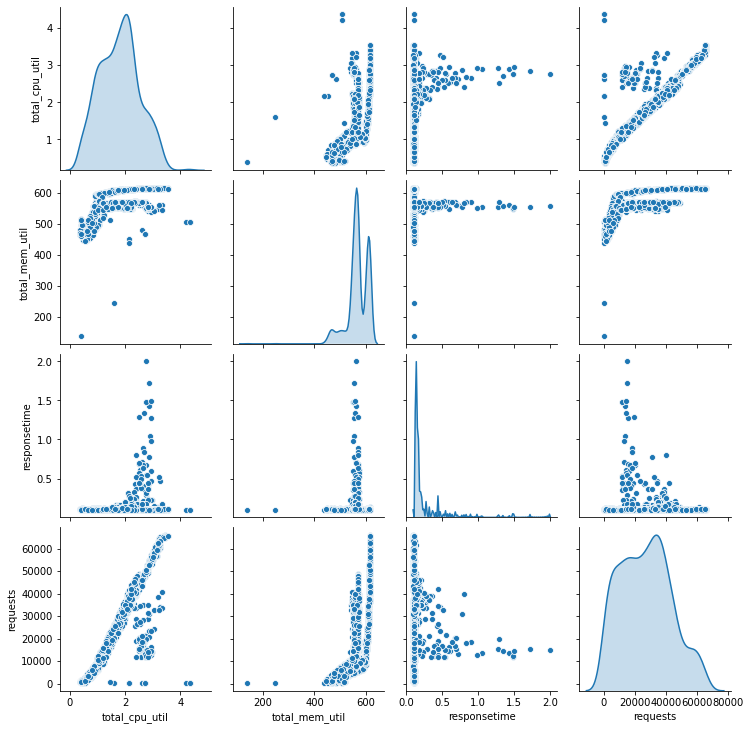

In [10]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,2063.0,1.802449,0.715306,0.369352,1.240840,1.819273,2.244835,4.363428
total_mem_util,2063.0,567.570779,39.498693,137.219482,552.863232,568.009114,604.695245,616.495718
responsetime,2063.0,0.129342,0.115991,0.099105,0.103883,0.107086,0.113091,1.999501
requests,2063.0,27122.444014,16215.375596,31.000000,13849.500000,26898.000000,38447.000000,66108.000000


In [12]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [13]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
259,1.923371,568.192205,0.103361,34174.0
1301,2.717520,612.240998,0.114410,48274.0
3131,1.957293,570.568704,0.103025,32914.0
3063,1.669178,570.091930,0.105804,26452.0
518,0.877700,480.162816,0.106193,5186.0


In [14]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [15]:
normalizer = preprocessing.Normalization()

In [16]:
normalizer.adapt(np.array(train_features))

In [17]:
print(normalizer.mean.numpy())

[  1.802 567.571   0.129]


## Linear Regression

In [18]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [19]:
model = tf.keras.Sequential([
    input_normalizer,
    layers.Dense(units=1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


In [20]:
model.predict(test_features)

array([[-1.326],
       [-1.336],
       [-1.376],
       [-1.32 ],
       [-1.265],
       [-1.298],
       [-1.276],
       [-1.296],
       [-1.309],
       [-1.283],
       [-1.334],
       [-1.342],
       [-1.345],
       [-1.352],
       [-1.307],
       [-1.3  ],
       [-1.297],
       [-1.306],
       [-1.36 ],
       [-1.326],
       [-1.257],
       [-1.299],
       [-1.334],
       [-1.329],
       [-1.264],
       [-1.329],
       [-1.334],
       [-1.337],
       [-1.27 ],
       [-1.259],
       [-1.334],
       [-1.341],
       [-1.337],
       [-1.362],
       [-1.297],
       [-1.288],
       [-1.319],
       [-1.292],
       [-1.339],
       [-1.285],
       [-1.32 ],
       [-1.312],
       [-1.302],
       [-1.322],
       [-1.281],
       [-1.303],
       [-1.3  ],
       [-1.304],
       [-1.289],
       [-1.308],
       [-1.323],
       [-1.285],
       [-1.327],
       [-1.321],
       [-1.312],
       [-1.304],
       [-1.298],
       [-1.281],
       [-1.313

In [21]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [22]:
%%time
history = model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 6.37 s, sys: 791 ms, total: 7.16 s
Wall time: 8.76 s


In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,26505.386719,27113.093750,95
96,26500.189453,27108.083984,96
97,26494.982422,27103.042969,97
98,26489.767578,27097.986328,98
99,26484.570312,27092.865234,99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 28000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

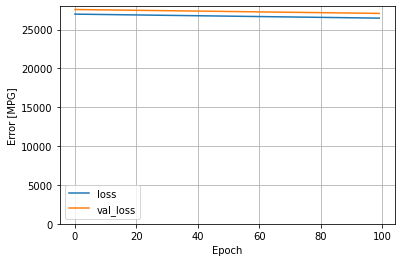

In [25]:
plot_loss(history)

In [26]:
test_results = {}

test_results['model'] = model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']],
    val_labels, verbose=0)

In [27]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [28]:
dnn_model = build_and_compile_model(input_normalizer)

In [29]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [30]:
%%time
history = dnn_model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.04 s, sys: 1.17 s, total: 10.2 s
Wall time: 10.6 s


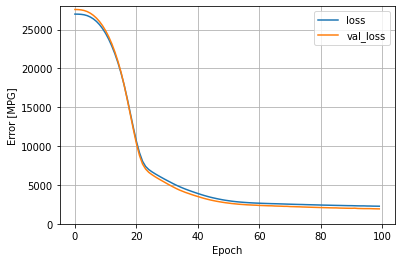

In [31]:
plot_loss(history)

In [32]:
test_results['dnn_model'] = dnn_model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']], val_labels,
    verbose=0)

In [33]:
pd.DataFrame(test_results, index=['requests']).T

,requests
model,26814.445312
dnn_model,2551.349365


## Make Predictions

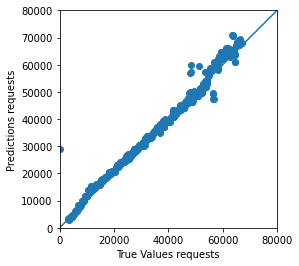

In [34]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values requests')
plt.ylabel('Predictions requests')
lims = [0, 80000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [35]:
from sklearn.metrics import r2_score
R = r2_score(test_labels, test_predictions)
print ('R² :',R)

R² : 0.9812953923737677


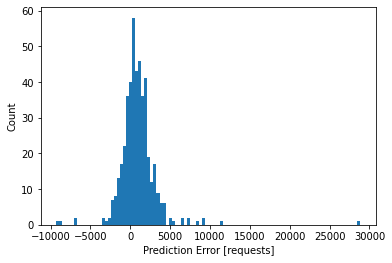

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')